In [75]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<img src="info/SchoolOfAI_MTY_Logo2.png" ,width=700,height=100 >

---

In [76]:
# import useful libraries
from ipywidgets import widgets, Layout
from IPython.display import display, clear_output, HTML, Image
import cv2
import matplotlib.pyplot as plt


# <center>Introduction to Deep Learning</center>

**RECALL**: Artificial neural networks (**ANN**) are computing systems that are **inspired by, but not necessarily identical to**, the biological neural networks that constitute **animal brains**. Such systems "learn" to perform tasks by considering examples, generally without being programmed with any task-specific rules. 

An ANN is based on a collection of connected units or nodes called **neurons**, which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal from one artificial neuron to another. 

![](info/NN_ANN.png)

**EXCERCISE**

What do you see? How would you classify them?

![](info/figures.png)

Button(description='And now?', layout=Layout(height='100px', width='100%'), style=ButtonStyle(button_color='wh…

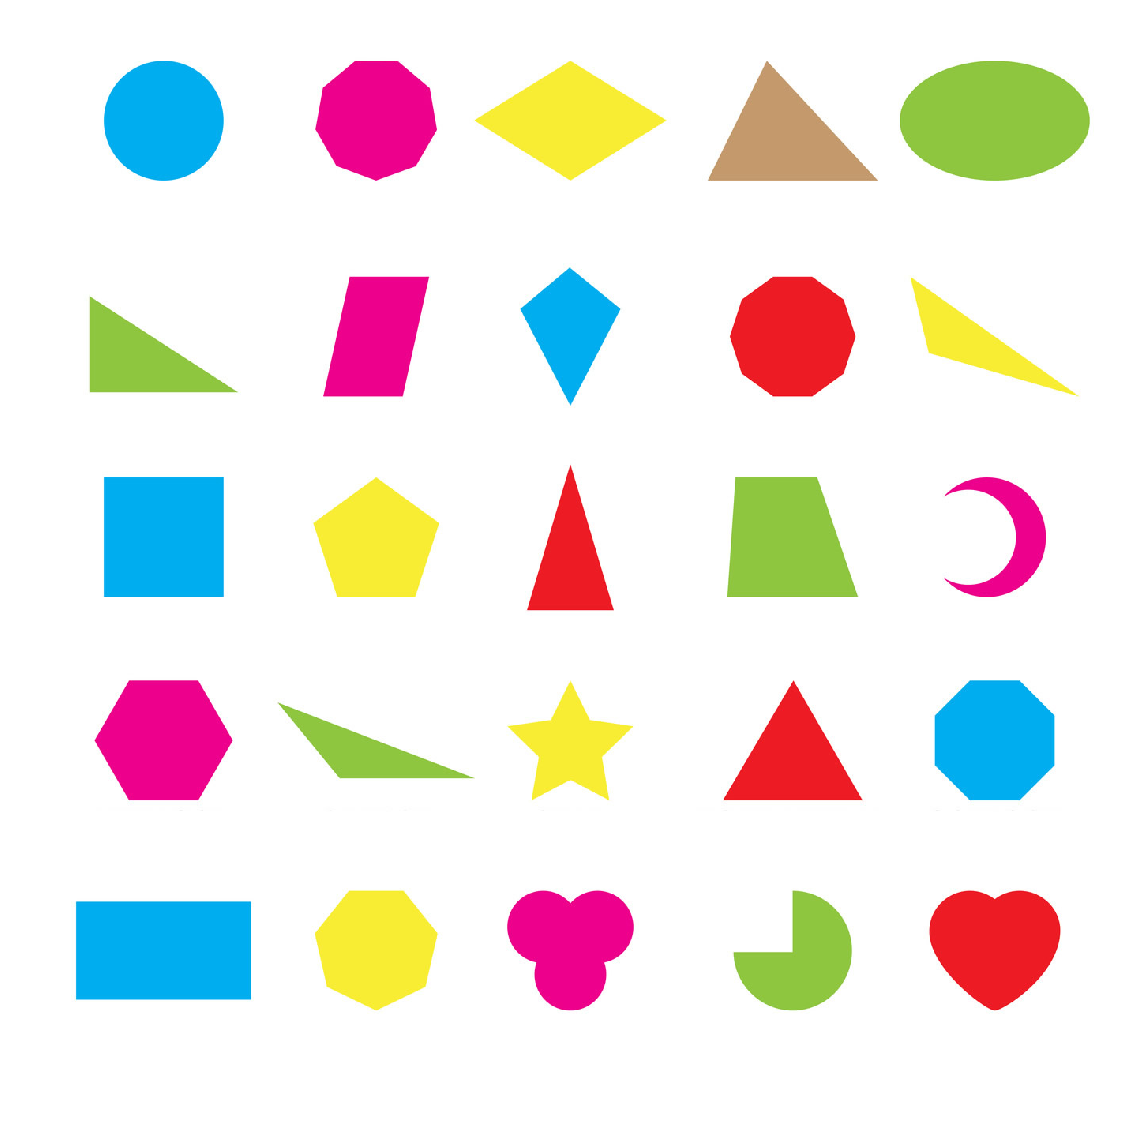

In [86]:
button = widgets.Button(description='And now?',
           layout=Layout(width='100%', height='100px'),style={'font_weight': 'bold', 
                                                              'button_color' : 'white',})
def discover(_):
    img = cv2.imread('info/figuras-geometricas-set.jpg')[:,:,::-1]
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.axis('off')
       
# linking button and function together using a button's method
button.on_click(discover)

# displaying widgets and its output together
# widgets.VBox([button,out])
display(button)

How does ML work?

- Input - An image, a text, a table with house properties, audio, etc

- **Representation** - Number of corners in the image, number of rooms or size, high frequencies, etc

- Model - Gets an input representation or feature (e.g. no. of corners) and applies metrics to detect the shape, i.e. square, triangle.

![](info/DL_ML_Representation.png)

The problem with these is that they were designed by humans based on heuristics. Images can be represented using these features and ML algorithms can be applied on top of that. However, they may not be the most optimal in terms of the objective function, i.e, it may be possible to design better features that can lead to lower objective function values. Instead of hand crafting these image representations, we can learn them. That is known as representation learning. We can have a neural network which takes the image as an input and outputs a vector, which is the feature representation of the image. This is the representation learner. This be followed by another neural network that acts as the classifier, regressor, etc . 

---

# <left>Deep Learning - Predicting house process</left>

In [302]:
# import libraries
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings('ignore')

## Load data

In [225]:
# load dataset
train = pd.read_csv('home_data.csv', header = 0)

In [226]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [227]:
# Compare total features against missing cells for each column
#  train.isnull().count() Number of non-NAN values
total_info = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
miss_info = pd.concat([total_info, percent], axis=1, keys=['Total', 'Percent'])
miss_info.T

,sqft_lot15,view,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sqft_living15,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,id
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


No missing data, awesome!

## Normalise data

There are different types of normalizations in statistics, we would be using the Min-Max Feature scaling that is used to bring all values into the range [0,1]. This is also called unity-based normalization. 
See: https://en.wikipedia.org/wiki/Normalization_(statistics) to check others normalization types

![](info/minmax.png)

Min-Max Normalisation modified:
$
x'=a+{\frac {\left(x-x_{\min }\right)\left(b-a\right)}{x_{\max }-x_{\min }}}
$

Implement Min-Max scaling in the `normalise()` function to a range of `a=0.1` and `b=0.9`. After scaling, the values of the pixels in the input data should range from 0.1 to 0.9.

In [228]:
# Normalise data
train = train.drop(['date'], axis=1) # drop non numerical columns
train_norm=(train-train.min())/(train.max()-train.min())
train_norm2=(train-train.mean())/(train.std())
print(len(train_norm))

21613


In [229]:
train_norm.head(5)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0.720103,0.019266,0.090909,0.12500,0.067170,0.003108,0.0,0.0,0.0,0.5,0.500000,0.097588,0.000000,0.478261,0.000000,0.893939,0.571498,0.217608,0.161934,0.005742
1,0.647853,0.060721,0.090909,0.28125,0.172075,0.004072,0.4,0.0,0.0,0.5,0.500000,0.206140,0.082988,0.443478,0.988089,0.626263,0.908959,0.166113,0.222165,0.008027
2,0.568795,0.013770,0.060606,0.12500,0.036226,0.005743,0.0,0.0,0.0,0.5,0.416667,0.052632,0.000000,0.286957,0.000000,0.136364,0.936143,0.237542,0.399415,0.008513
3,0.251157,0.069377,0.121212,0.37500,0.126038,0.002714,0.0,0.0,0.0,1.0,0.500000,0.083333,0.188797,0.565217,0.000000,0.681818,0.586939,0.104651,0.165376,0.004996
4,0.197333,0.057049,0.090909,0.25000,0.104906,0.004579,0.0,0.0,0.0,0.5,0.583333,0.152412,0.000000,0.756522,0.000000,0.368687,0.741354,0.393688,0.241094,0.007871


In [230]:
train_norm2.head(5)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0.886126,-0.866697,-0.398728,-1.447430,-0.979812,-0.228316,-0.915406,-0.087171,-0.305752,-0.629172,-0.558823,-0.734691,-0.658666,-0.544885,-0.210124,1.870108,-0.352564,-0.306072,-0.943333,-0.260709
1,0.637496,-0.005688,-0.398728,0.175603,0.533622,-0.189881,0.936484,-0.087171,-0.305752,-0.629172,-0.558823,0.460830,0.245136,-0.681063,4.746568,0.879547,1.161541,-0.746324,-0.432676,-0.187863
2,0.365435,-0.980827,-1.473925,-1.447430,-1.426221,-0.123296,-0.915406,-0.087171,-0.305752,-0.629172,-1.409554,-1.229805,-0.658666,-1.293862,-0.210124,-0.933367,1.283507,-0.135652,1.070115,-0.172371
3,-0.727639,0.174086,0.676469,1.149422,-0.130547,-0.244009,-0.915406,-0.087171,-0.305752,2.444237,-0.558823,-0.891678,1.397483,-0.204441,-0.210124,1.085135,-0.283281,-1.271787,-0.914153,-0.284515
4,-0.912860,-0.081956,-0.398728,-0.149004,-0.435412,-0.169649,-0.915406,-0.087171,-0.305752,-0.629172,0.291909,-0.130892,-0.658666,0.544535,-0.210124,-0.073634,0.409541,1.199307,-0.272184,-0.192844


## Split data!

The goal of any Machine Learning / Deep Learning model is to generalise and prevent overfitting! 

An overfit model gets a low loss during training but does a poor job predicting new data. If a model fits the current sample well, how can we trust that it will make good predictions on new data?

To address this, we can split the dataset into three subsets. This is a common practice since it helps to measure performance of models in a real scenario on unseen data and also important to prevent overfitting.

In [231]:
'''split = np.random.rand(len(train_norm)) < 0.8
train = train_norm[split]
validate = train_norm[~split]

print('{0} observations for Trainig '.format(len(train)))
print('{0} observations for Testing '.format(len(validate)))'''

"split = np.random.rand(len(train_norm)) < 0.8\ntrain = train_norm[split]\nvalidate = train_norm[~split]\n\nprint('{0} observations for Trainig '.format(len(train)))\nprint('{0} observations for Testing '.format(len(validate)))"

In [232]:
train, validate, test = np.split(train_norm.sample(frac=1), [int(.70*len(df)), int(.85*len(df))])
print('------------------------------------')
print('{0} observations for Trainig '.format(len(train)))
print('{0} observations for Testing '.format(len(validate)))
print('{0} observations for Testing '.format(len(test)))

------------------------------------
15129 observations for Trainig 
3242 observations for Testing 
3242 observations for Testing 


## Train the Model

In [233]:
# Create model
model = Sequential()
# Input of 3 features. 
# Play around with the number of neurons!!
model.add(Dense(3, input_dim=3))
# Add another Densely Connected layer (every neuron connected to every neuron in the next layer)
model.add(Dense(8, activation='relu'))
# Last layer simple sigmoid function to output 0 or 1 (our label)
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])

X_train = train[['sqft_living', 'grade', 'sqft_above']]
Y_train = train["price"]
X_val = validate[['sqft_living', 'grade', 'sqft_above']]
Y_val = validate["price"]
# Play around with number of epochs as well!
#model.fit(X_train,Y_train,epochs=500, verbose=2, batch_size = 500)

hist = model.fit(X_train, Y_train,
          batch_size=128, epochs=100,
          validation_data=(X_val, Y_val)) #, callbacks=[plot_losses]

Train on 15129 samples, validate on 3242 samples
Epoch 1/100
15129/15129 [==============================] - 1s 45us/step - loss: 0.1122 - mean_squared_error: 0.1122 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 2/100
15129/15129 [==============================] - 0s 12us/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 3/100
15129/15129 [==============================] - 0s 10us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 4/100
15129/15129 [==============================] - 0s 9us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 5/100
15129/15129 [==============================] - 0s 9us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 6/100
15129/15129 [==============================] - 0s 9us/step - loss: 0.0036 - mean_squared_error: 0.003

15129/15129 [==============================] - 0s 9us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.8832e-04 - val_mean_squared_error: 9.8832e-04
Epoch 50/100
15129/15129 [==============================] - 0s 11us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.4857e-04 - val_mean_squared_error: 9.4857e-04
Epoch 51/100
15129/15129 [==============================] - 0s 11us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.2896e-04 - val_mean_squared_error: 9.2896e-04
Epoch 52/100
15129/15129 [==============================] - 0s 10us/step - loss: 9.8490e-04 - mean_squared_error: 9.8490e-04 - val_loss: 9.1355e-04 - val_mean_squared_error: 9.1355e-04
Epoch 53/100
15129/15129 [==============================] - 0s 10us/step - loss: 9.7038e-04 - mean_squared_error: 9.7038e-04 - val_loss: 8.9646e-04 - val_mean_squared_error: 8.9646e-04
Epoch 54/100
15129/15129 [==============================] - 0s 9us/step - loss: 9.5990e-04 - mean_squared_error: 

Epoch 94/100
15129/15129 [==============================] - 0s 9us/step - loss: 9.0743e-04 - mean_squared_error: 9.0743e-04 - val_loss: 8.4759e-04 - val_mean_squared_error: 8.4759e-04
Epoch 95/100
15129/15129 [==============================] - 0s 8us/step - loss: 9.0683e-04 - mean_squared_error: 9.0683e-04 - val_loss: 8.5670e-04 - val_mean_squared_error: 8.5670e-04
Epoch 96/100
15129/15129 [==============================] - 0s 8us/step - loss: 9.0675e-04 - mean_squared_error: 9.0675e-04 - val_loss: 8.4542e-04 - val_mean_squared_error: 8.4542e-04
Epoch 97/100
15129/15129 [==============================] - 0s 9us/step - loss: 9.0700e-04 - mean_squared_error: 9.0700e-04 - val_loss: 8.4545e-04 - val_mean_squared_error: 8.4545e-04
Epoch 98/100
15129/15129 [==============================] - 0s 9us/step - loss: 9.0742e-04 - mean_squared_error: 9.0742e-04 - val_loss: 8.4652e-04 - val_mean_squared_error: 8.4652e-04
Epoch 99/100
15129/15129 [==============================] - 0s 10us/step - loss:

In [318]:
print('-------------------------------------------')
print('Model Layers: ')
model.layers

In [307]:
X_test = test[['sqft_living', 'grade', 'sqft_above']]
Y_test = test["price"]
model.evaluate(X_test,Y_test)[1]

3242/3242 [==============================] - 0s 29us/step


0.00106423771332241

In [247]:
test["pred"] = model.predict(X_test)
print("MSE - Mean squared error:", metrics.mean_squared_error(test["price"], test["pred"]))
print("Variance score:", metrics.r2_score(test["price"], test["pred"]))

MSE - Mean squared error: 0.001022984315233291
Variance score: 0.6077359355066434


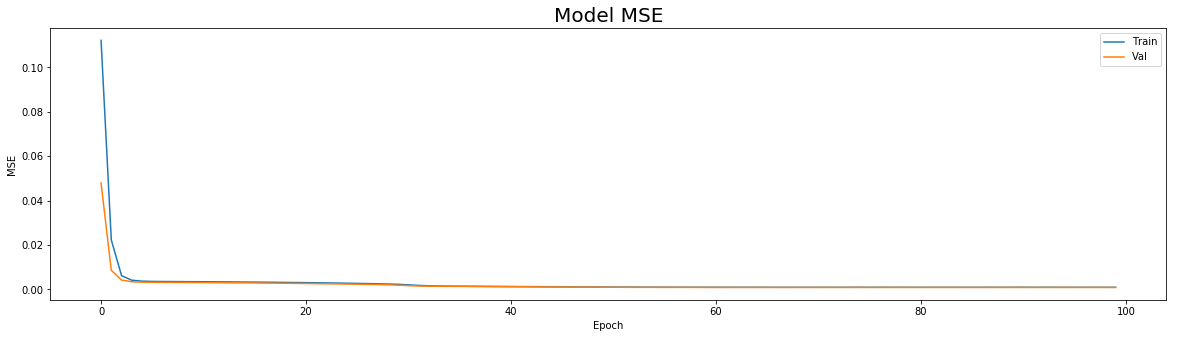

In [259]:
fig = plt.figure(figsize=(20,5))
plt.plot(hist.history['mean_squared_error'])
plt.plot(hist.history['val_mean_squared_error'])
plt.title('Model MSE', fontsize=20)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

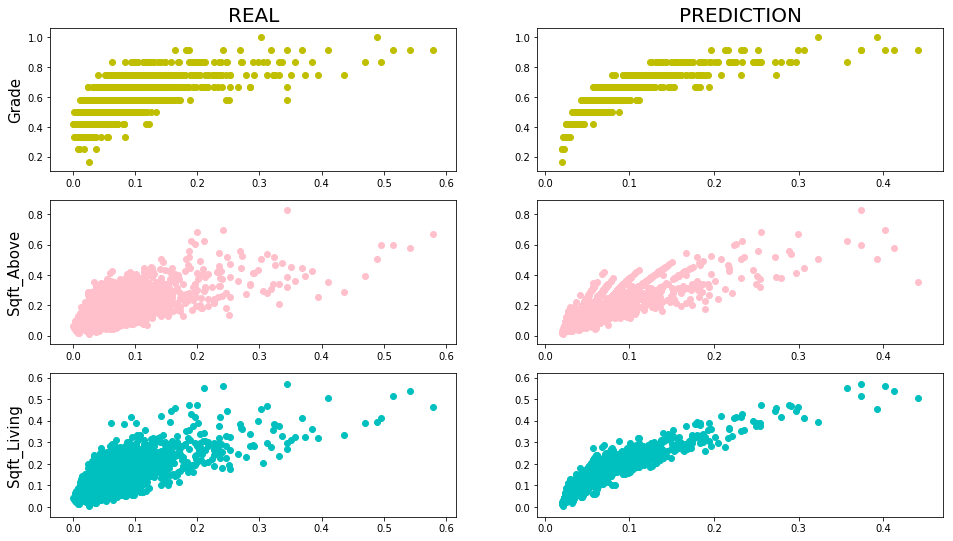

In [258]:
plt.subplots(3,2, figsize = (16,9),)

plt.subplot(3,2,1)
plt.title('REAL', fontsize=20)
plt.scatter(test["price"], test["grade"],c= 'y')
plt.ylabel('Grade',fontsize = 15)

plt.subplot(3, 2, 2)
plt.title('PREDICTION', fontsize=20)
plt.scatter(test["pred"], test["grade"], c='y')

plt.subplot(3,2,3)
plt.scatter(test["price"], test["sqft_above"], c='pink')
plt.ylabel('Sqft_Above', fontsize = 15)

plt.subplot(3, 2, 4)
plt.scatter(test["pred"], test["sqft_above"], c='pink')

plt.subplot(3,2,5)
plt.scatter(test["price"], test["sqft_living"], c='c')
plt.ylabel('Sqft_Living', fontsize = 15)

plt.subplot(3, 2, 6)
plt.scatter(test["pred"], test["sqft_living"], c= 'c')

plt.show()

## Train the Model - Let's go DEEPER

In [315]:
# Create model
model = Sequential()
    
# Add first connected layer
model.add(Dense(3, activation="tanh", input_dim=3)) # Expects input of 3 features. 
# Add another Densely Connected layer (every neuron connected to every neuron in the next layer)
model.add(Dense(50, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1))
# Last layer simple sigmoid function to output 0 or 1 (our label)
model.add(Dense(1)) # We don't use activation='sigmoid' since we want to predict a continuous variable

# Compile model, i.e. defines the loss function, the optimizer and the metrics
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])

# Define inputs
X_train = train[['sqft_living', 'grade', 'sqft_above']]
Y_train = train["price"]
X_val = validate[['sqft_living', 'grade', 'sqft_above']]
Y_val = validate["price"]

# Train
checkpointer = ModelCheckpoint(filepath='saved_models/model_SoAI.h5', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00000001, patience=20, verbose=1, mode='auto')

hist = model.fit(X_train, Y_train,
          batch_size=128, epochs=100,
          validation_data=(X_val, Y_val),
          callbacks=[checkpointer, early_stopping], verbose=1)

Train on 15129 samples, validate on 3242 samples
Epoch 1/100
15129/15129 [==============================] - 1s 90us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0010 - val_mean_squared_error: 0.0010

Epoch 00001: val_loss improved from inf to 0.00100, saving model to saved_models/model_SoAI.h5
Epoch 2/100
15129/15129 [==============================] - 0s 17us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 8.6193e-04 - val_mean_squared_error: 8.6193e-04

Epoch 00002: val_loss improved from 0.00100 to 0.00086, saving model to saved_models/model_SoAI.h5
Epoch 3/100
15129/15129 [==============================] - 0s 18us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 8.3434e-04 - val_mean_squared_error: 8.3434e-04

Epoch 00003: val_loss improved from 0.00086 to 0.00083, saving model to saved_models/model_SoAI.h5
Epoch 4/100
15129/15129 [==============================] - 0s 17us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 8.9508e

In [323]:
print('-------------------------------------------')
print('Model Layers: ')
model.layers

-------------------------------------------
Model Layers: 


In [316]:
X_test = test[['sqft_living', 'grade', 'sqft_above']]
Y_test = test["price"]
model.evaluate(X_test,Y_test)[1]

3242/3242 [==============================] - 0s 33us/step


0.0010206579740051776

In [317]:
test["pred"] = model.predict(X_test)
print("MSE - Mean squared error:", metrics.mean_squared_error(test["price"], test["pred"]))
print("Variance score:", metrics.r2_score(test["price"], test["pred"]))

MSE - Mean squared error: 0.001020657970949312
Variance score: 0.6086279738797209


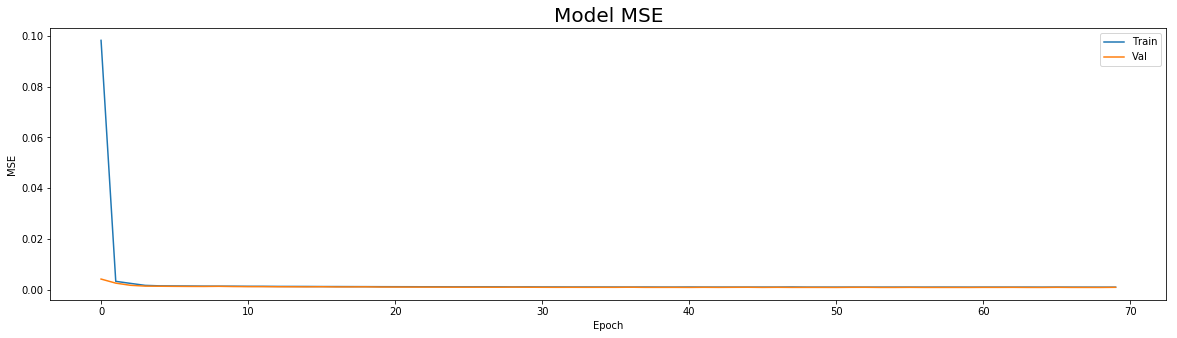

In [286]:
fig = plt.figure(figsize=(20,5))
plt.plot(hist.history['mean_squared_error'])
plt.plot(hist.history['val_mean_squared_error'])
plt.title('Model MSE', fontsize=20)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

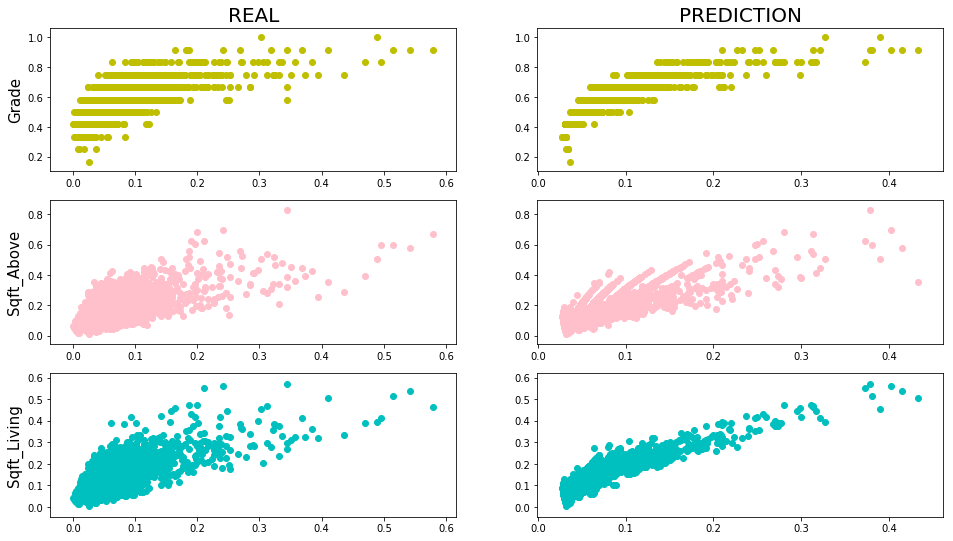

In [287]:
plt.subplots(3,2, figsize = (16,9),)

plt.subplot(3,2,1)
plt.title('REAL', fontsize=20)
plt.scatter(test["price"], test["grade"],c= 'y')
plt.ylabel('Grade',fontsize = 15)

plt.subplot(3, 2, 2)
plt.title('PREDICTION', fontsize=20)
plt.scatter(test["pred"], test["grade"], c='y')

plt.subplot(3,2,3)
plt.scatter(test["price"], test["sqft_above"], c='pink')
plt.ylabel('Sqft_Above', fontsize = 15)

plt.subplot(3, 2, 4)
plt.scatter(test["pred"], test["sqft_above"], c='pink')

plt.subplot(3,2,5)
plt.scatter(test["price"], test["sqft_living"], c='c')
plt.ylabel('Sqft_Living', fontsize = 15)

plt.subplot(3, 2, 6)
plt.scatter(test["pred"], test["sqft_living"], c= 'c')

plt.show()

19

## Train the Model - Let's go DEEPER - FULL DATASET

In [333]:
# Create model
model = Sequential()
    
# Add first connected layer
model.add(Dense(3, activation="tanh", input_dim=train.shape[1] - 1)) # Expects input of 3 features. 
# Add another Densely Connected layer (every neuron connected to every neuron in the next layer)
model.add(Dense(50, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1))
# Last layer simple sigmoid function to output 0 or 1 (our label)
model.add(Dense(1)) # We don't use activation='sigmoid' since we want to predict a continuous variable

# Compile model, i.e. defines the loss function, the optimizer and the metrics
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])

# Define inputs
X_train = train.loc[:, train.columns != 'price']
Y_train = train["price"]

X_val = validate.loc[:, validate.columns != 'price']
Y_val = validate["price"]

# Train
checkpointer = ModelCheckpoint(filepath='saved_models/model_SoAI.h5', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00000001, patience=20, verbose=1, mode='auto')

hist = model.fit(X_train, Y_train,
          batch_size=128, epochs=100,
          validation_data=(X_val, Y_val),
          callbacks=[checkpointer, early_stopping], verbose=1)

Train on 15129 samples, validate on 3242 samples
Epoch 1/100
15129/15129 [==============================] - 1s 98us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0011 - val_mean_squared_error: 0.0011

Epoch 00001: val_loss improved from inf to 0.00108, saving model to saved_models/model_SoAI.h5
Epoch 2/100
15129/15129 [==============================] - 0s 16us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 8.5442e-04 - val_mean_squared_error: 8.5442e-04

Epoch 00002: val_loss improved from 0.00108 to 0.00085, saving model to saved_models/model_SoAI.h5
Epoch 3/100
15129/15129 [==============================] - 0s 17us/step - loss: 9.2877e-04 - mean_squared_error: 9.2877e-04 - val_loss: 7.4353e-04 - val_mean_squared_error: 7.4353e-04

Epoch 00003: val_loss improved from 0.00085 to 0.00074, saving model to saved_models/model_SoAI.h5
Epoch 4/100
15129/15129 [==============================] - 0s 17us/step - loss: 8.1599e-04 - mean_squared_error: 8.1599e-04 - v

15129/15129 [==============================] - 0s 18us/step - loss: 5.0779e-04 - mean_squared_error: 5.0779e-04 - val_loss: 5.6057e-04 - val_mean_squared_error: 5.6057e-04

Epoch 00033: val_loss did not improve from 0.00056
Epoch 34/100
15129/15129 [==============================] - 0s 17us/step - loss: 5.0502e-04 - mean_squared_error: 5.0502e-04 - val_loss: 6.0672e-04 - val_mean_squared_error: 6.0672e-04

Epoch 00034: val_loss did not improve from 0.00056
Epoch 35/100
15129/15129 [==============================] - 0s 15us/step - loss: 5.0880e-04 - mean_squared_error: 5.0880e-04 - val_loss: 5.8426e-04 - val_mean_squared_error: 5.8426e-04

Epoch 00035: val_loss did not improve from 0.00056
Epoch 36/100
15129/15129 [==============================] - 0s 14us/step - loss: 5.0187e-04 - mean_squared_error: 5.0187e-04 - val_loss: 6.1504e-04 - val_mean_squared_error: 6.1504e-04

Epoch 00036: val_loss did not improve from 0.00056
Epoch 37/100
15129/15129 [==============================] - 0s 16

In [334]:
print('-------------------------------------------')
print('Model Layers: ')
model.layers

-------------------------------------------
Model Layers: 


In [347]:
X_test = test[test.columns.difference(['price', 'pred'])]
Y_test = test["price"]
model.evaluate(X_test,Y_test)[1]

3242/3242 [==============================] - 0s 35us/step


0.003926463205830403

In [348]:
test["pred"] = model.predict(X_test)
print("MSE - Mean squared error:", metrics.mean_squared_error(test["price"], test["pred"]))
print("Variance score:", metrics.r2_score(test["price"], test["pred"]))

MSE - Mean squared error: 0.0039264631615068615
Variance score: -0.5056050966576866


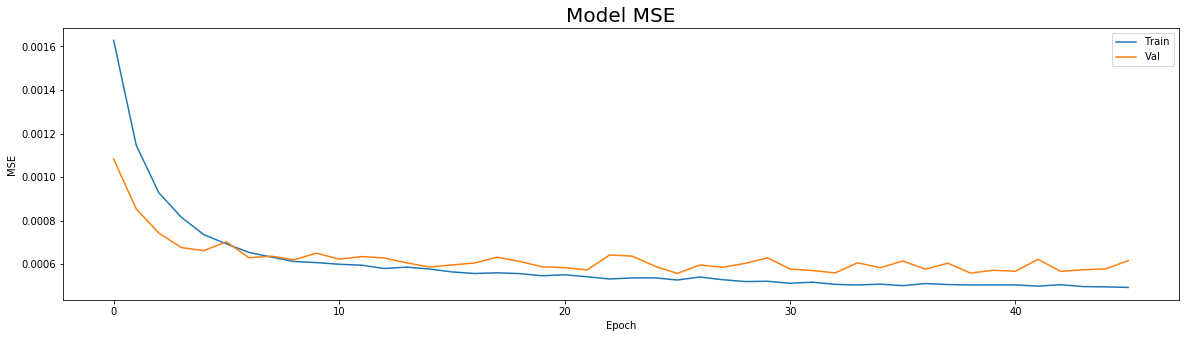

In [349]:
fig = plt.figure(figsize=(20,5))
plt.plot(hist.history['mean_squared_error'])
plt.plot(hist.history['val_mean_squared_error'])
plt.title('Model MSE', fontsize=20)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

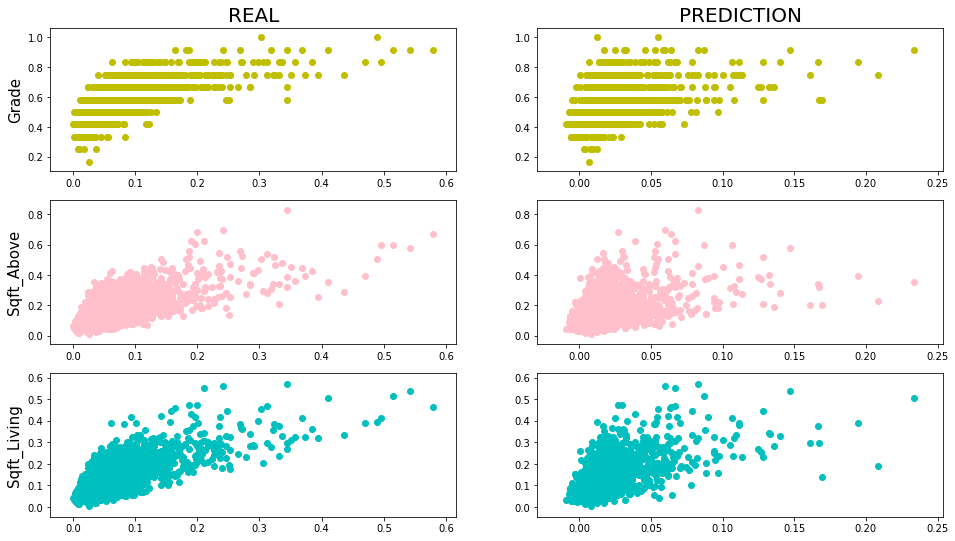

In [350]:
plt.subplots(3,2, figsize = (16,9),)

plt.subplot(3,2,1)
plt.title('REAL', fontsize=20)
plt.scatter(test["price"], test["grade"],c= 'y')
plt.ylabel('Grade',fontsize = 15)

plt.subplot(3, 2, 2)
plt.title('PREDICTION', fontsize=20)
plt.scatter(test["pred"], test["grade"], c='y')

plt.subplot(3,2,3)
plt.scatter(test["price"], test["sqft_above"], c='pink')
plt.ylabel('Sqft_Above', fontsize = 15)

plt.subplot(3, 2, 4)
plt.scatter(test["pred"], test["sqft_above"], c='pink')

plt.subplot(3,2,5)
plt.scatter(test["price"], test["sqft_living"], c='c')
plt.ylabel('Sqft_Living', fontsize = 15)

plt.subplot(3, 2, 6)
plt.scatter(test["pred"], test["sqft_living"], c= 'c')

plt.show()